# Educational Reading Level Classification Analysis

## Load data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Create pandas dataframes from csv files
id_df = pd.read_csv("data/id_df.csv", index_col = 0)
ood_df = pd.read_csv("data/ood_df.csv", index_col = 0)

## Clean data

In [3]:
# Create dataframes of misclassified passages only
id_errors_df = id_df[id_df['true_label'] != id_df['pred_label']].copy()
ood_errors_df = ood_df[ood_df['true_label'] != ood_df['pred_label']].copy()

## Error Analysis (in-domain)

In [4]:
label_map = {0: "elementary", 1: "middle", 2: "high"}

# Converting the numeric true/pred labels into respective string labels
id_errors_df["true_label_str"] = id_errors_df["true_label"].map(label_map)
id_errors_df["pred_label_str"] = id_errors_df["pred_label"].map(label_map)

print(f"Total test examples: {len(id_df)}")
print(f"Correct classification: {len(id_df) - len(id_errors_df)}")
print(f"Incorrect classification: {len(id_errors_df)}")

Total test examples: 773
Correct classification: 613
Incorrect classification: 160


In [5]:
# Analyzing passage length based on characters and words for misclassified text

id_errors_df["char_len"] = id_errors_df["text"].str.len()
id_errors_df["word_len"] = id_errors_df["text"].str.split().str.len()

print("\nAverage passage length (chars/words) for misclassified examples by true label:")
display(
    id_errors_df.groupby("true_label_str")[["char_len", "word_len"]]
    .mean()
    .round(2)
)


Average passage length (chars/words) for misclassified examples by true label:


,char_len,word_len
true_label_str,,
elementary,160.15,29.80
high,356.85,65.97
middle,314.00,58.34


In [6]:
# Compute average sentence length (words per sentence) per passage

def split_sentences(text: str):
    # Splits on period, question mark, or exclamation followed by a space

    if not isinstance(text, str):
        return []
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())

    # Remove empty strings if any
    return [s for s in sentences if s.strip()]

avg_sentence_lengths = []

for text in id_df["text"]:
    sentences = split_sentences(text)

    if len(sentences) == 0:
        avg_sentence_lengths.append(0.0)
        continue

    word_counts = [len(s.split()) for s in sentences]
    avg_sentence_lengths.append(sum(word_counts) / len(word_counts))

id_df["avg_sentence_length"] = avg_sentence_lengths

id_df[["text", "true_label", "pred_label", "num_words", "avg_sentence_length"]].head()

,text,true_label,pred_label,num_words,avg_sentence_length
Unnamed: 0,,,,,
0,Those were the best days. When one of them man...,1,0,39,19.500000
1,"His impulses were still near the surface, and ...",2,2,36,18.000000
2,Mrs. Murry stroked Meg’s shaggy head. “Do you ...,0,0,10,3.333333
3,"""And we're very hungry right now. In fact, I c...",0,0,15,7.500000
4,"But if ’t be he I mean, he’s very wild, Addict...",2,2,53,53.000000


Average sentence length by TRUE label:
            count       mean        std       min     25%        50%  \
true_label                                                             
0           240.0  13.532315   8.077557  1.666667   8.000  11.416667   
1           276.0  20.042529  11.246251  3.500000  11.725  18.000000   
2           257.0  23.012277  19.047424  4.000000  13.000  18.714286   

                  75%    max  
true_label                    
0           18.000000   48.0  
1           24.812500   73.0  
2           25.333333  176.0  

Average sentence length by PREDICTED label:
            count       mean        std       min        25%        50%  \
pred_label                                                                
0           274.0  14.378692   9.360845  1.666667   8.000000  11.833333   
1           263.0  20.363210  11.021848  3.500000  12.633333  18.666667   
2           236.0  22.874420  19.486251  2.000000  12.225155  18.416667   

                  75%   

<Figure size 800x500 with 0 Axes>

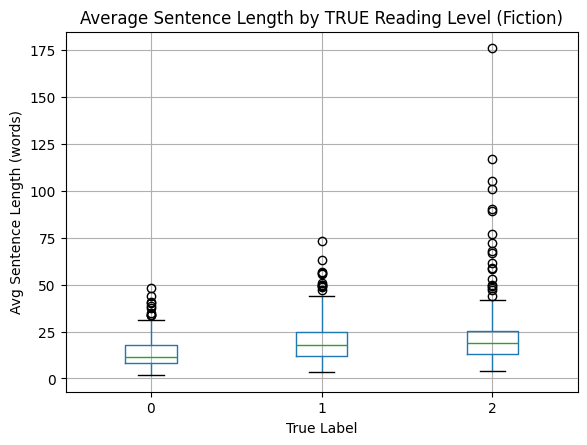

<Figure size 800x500 with 0 Axes>

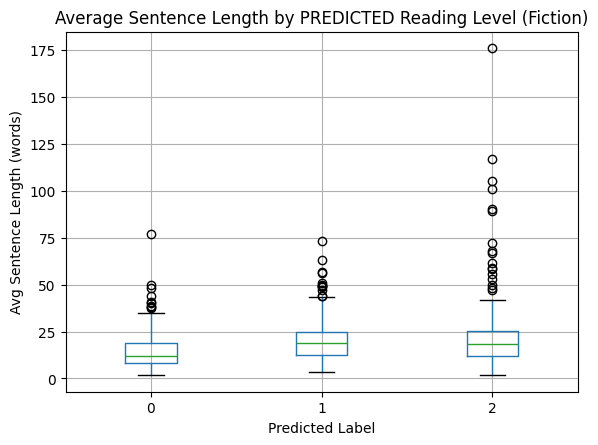

In [7]:
print("Average sentence length by TRUE label:")
print(id_df.groupby("true_label")["avg_sentence_length"].describe())

print("\nAverage sentence length by PREDICTED label:")
print(id_df.groupby("pred_label")["avg_sentence_length"].describe())

plt.figure(figsize=(8, 5))
id_df.boxplot(column="avg_sentence_length", by="true_label")
plt.title("Average Sentence Length by TRUE Reading Level (Fiction)")
plt.suptitle("")
plt.xlabel("True Label")
plt.ylabel("Avg Sentence Length (words)")
plt.show()

plt.figure(figsize=(8, 5))
id_df.boxplot(column="avg_sentence_length", by="pred_label")
plt.title("Average Sentence Length by PREDICTED Reading Level (Fiction)")
plt.suptitle("")
plt.xlabel("Predicted Label")
plt.ylabel("Avg Sentence Length (words)")
plt.show()


 Confusion Matrix (rows = TRUE, columns = PREDICTED):


,elementary,middle,high
elementary,220,11,9
middle,38,202,36
high,16,50,191


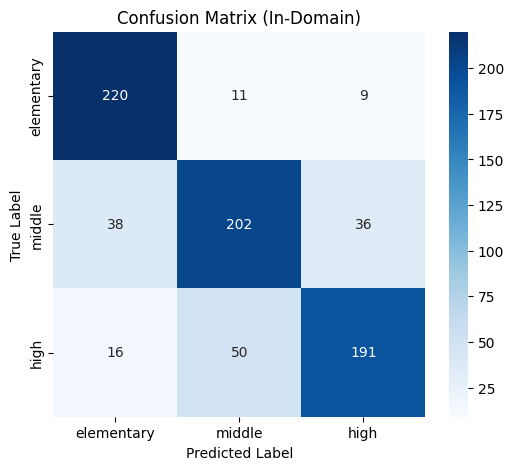

In [8]:
# Label map (same as OOD)
label_map = {0: "elementary", 1: "middle", 2: "high"}

# Convert true labels → strings
id_true_str = [label_map.get(int(x), x) for x in id_df['true_label']]

# Convert predicted labels → strings
id_pred_str = [label_map.get(int(x), x) for x in id_df['pred_label']]

class_names = ["elementary", "middle", "high"]

# In-Domain confusion matrix
cm_id = confusion_matrix(id_true_str, id_pred_str, labels=class_names)
cm_id_df = pd.DataFrame(cm_id, index=class_names, columns=class_names)

print("\n Confusion Matrix (rows = TRUE, columns = PREDICTED):")
display(cm_id_df)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_id_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (In-Domain)")
plt.show()

In [9]:
# more detail on misclassified samples
misclass_table = (
    id_errors_df
    .groupby(["true_label_str", "pred_label_str"])
    .size()
    .unstack(fill_value=0)
)

print("\nMisclassified counts (rows = TRUE label, cols = PREDICTED label):")
display(misclass_table)

labels_of_interest = ["elementary", "middle", "high"]

print("\n Misclassification breakdown by true label:")
for true_lab in labels_of_interest:
    if true_lab not in misclass_table.index:
        # skip labels that don’t appear in the misclassified set
        continue
    row = misclass_table.loc[true_lab]
    print(f"\nTrue label = {true_lab}:")
    for pred_lab, count in row.items():
        if pred_lab == true_lab:
            continue
        print(f"  Misclassified as {pred_lab}: {count} examples")


Misclassified counts (rows = TRUE label, cols = PREDICTED label):


pred_label_str,elementary,high,middle
true_label_str,,,
elementary,0,9,11
high,16,0,50
middle,38,36,0



 Misclassification breakdown by true label:

True label = elementary:
  Misclassified as high: 9 examples
  Misclassified as middle: 11 examples

True label = middle:
  Misclassified as elementary: 38 examples
  Misclassified as high: 36 examples

True label = high:
  Misclassified as elementary: 16 examples
  Misclassified as middle: 50 examples


In [10]:
# Converting true labels to strings for analysis
id_true_str = [label_map.get(x, x) for x in id_df['true_label']]
id_errors_df["true_label"] = id_errors_df["true_label"].map(label_map).fillna(id_errors_df["true_label"])

In [11]:
# Per-class error summary (elementary, middle, high)

all_labels = ["elementary", "middle", "high"]

present_labels = sorted(set(id_true_str))
id_unique_labels = [lbl for lbl in all_labels if lbl in present_labels]

# Misclassified count per true class (using id_errors_df)
mis_per_class = [
    (id_errors_df["true_label"] == lbl).sum()
    for lbl in id_unique_labels
]

# Total count per class using all test data
total_per_class = [
    sum(1 for x in id_true_str if x == lbl)
    for lbl in id_unique_labels
]

# Building a summary table
summary_rows = []
for i, lbl in enumerate(id_unique_labels):
    total = total_per_class[i]
    mis   = mis_per_class[i]
    correct = total - mis
    err_rate = mis / total if total > 0 else 0.0
    summary_rows.append({
        "true_label": lbl,
        "total_examples": total,
        "correct": correct,
        "misclassified": mis,
        "error_rate": err_rate,
    })

summary_df = pd.DataFrame(summary_rows)
summary_df["error_rate_percent"] = (summary_df["error_rate"] * 100).round(1)

print("\nPer-class error summary (labels: elementary, middle, high):")
display(summary_df)



Per-class error summary (labels: elementary, middle, high):


,true_label,total_examples,correct,misclassified,error_rate,error_rate_percent
0,elementary,240,220,20,0.083333,8.3
1,middle,276,202,74,0.268116,26.8
2,high,257,191,66,0.256809,25.7


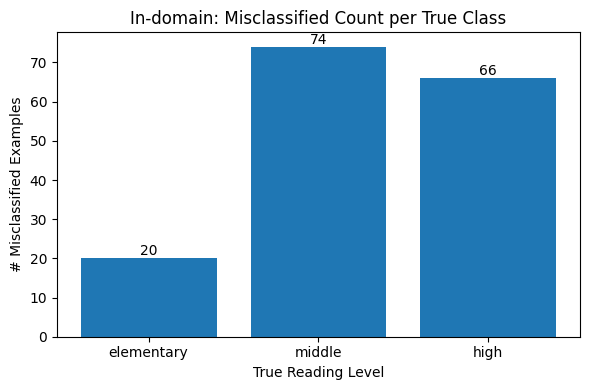

In [12]:
# Bar plot – misclassified count per true class

plt.figure(figsize=(6, 4))
bars = plt.bar(range(len(id_unique_labels)), mis_per_class)
plt.xticks(range(len(id_unique_labels)), id_unique_labels)
plt.xlabel("True Reading Level")
plt.ylabel("# Misclassified Examples")
plt.title("In-domain: Misclassified Count per True Class")

for idx, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

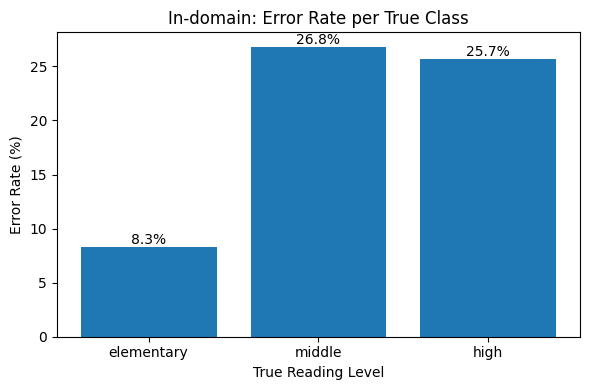

In [13]:
# Bar plot – error rate per true class (percentage)

id_error_rates = [
    mis_per_class[i] / total_per_class[i] if total_per_class[i] > 0 else 0.0
    for i in range(len(id_unique_labels))
]

plt.figure(figsize=(6, 4))
bars = plt.bar(range(len(id_unique_labels)), [r * 100 for r in id_error_rates])
plt.xticks(range(len(id_unique_labels)), id_unique_labels)
plt.xlabel("True Reading Level")
plt.ylabel("Error Rate (%)")
plt.title("In-domain: Error Rate per True Class")

for idx, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

In [14]:
label_map = {0: "elementary", 1: "middle", 2: "high"}
ordinal_map = {"elementary": 0, "middle": 1, "high": 2}

id_true_str = [label_map.get(x, x) for x in id_df['true_label']]
id_pred_str = [label_map.get(x, x) for x in id_df['pred_label']]

true_ids = [ordinal_map[lbl] for lbl in id_true_str]
pred_ids = [ordinal_map[lbl] for lbl in id_pred_str]

# Distance-based error analysis (checking how far off are the wrong predictions)

distances = []
for t, p in zip(true_ids, pred_ids):
    distances.append(abs(t - p))

total_examples = len(distances)
total_errors = sum(d > 0 for d in distances)

one_away = sum(d == 1 for d in distances)
two_away = sum(d == 2 for d in distances)

print(f"Total examples: {total_examples}")
print(f"Total incorrect predictions: {total_errors}")

print("\nAmong incorrect predictions:")
print(f"  1 level away: {one_away}")
print(f"  2 levels away: {two_away}")

if total_errors > 0:
    print(f"\nFraction of errors that are 1 level away: {one_away / total_errors:.3f}")
    print(f"Fraction of errors that are 2 levels away: {two_away / total_errors:.3f}")


Total examples: 773
Total incorrect predictions: 160

Among incorrect predictions:
  1 level away: 135
  2 levels away: 25

Fraction of errors that are 1 level away: 0.844
Fraction of errors that are 2 levels away: 0.156


In [15]:
# Correct vs Incorrect Predictions & Length

id_df["is_correct"] = (id_df["true_label"] == id_df["pred_label"]).astype(int)

print("\nAccuracy by true label (in-domain):")
print(id_df.groupby("true_label")["is_correct"].mean())

print("\nAccuracy by predicted label (in-domain):")
print(id_df.groupby("pred_label")["is_correct"].mean())

print("\nPassage length for correct vs incorrect predictions:")
print(id_df.groupby("is_correct")["num_words"].describe())

print("\nAverage sentence length for correct vs incorrect predictions:")
print(id_df.groupby("is_correct")["avg_sentence_length"].describe())


Accuracy by true label (in-domain):
true_label
0    0.916667
1    0.731884
2    0.743191
Name: is_correct, dtype: float64

Accuracy by predicted label (in-domain):
pred_label
0    0.802920
1    0.768061
2    0.809322
Name: is_correct, dtype: float64

Passage length for correct vs incorrect predictions:
            count       mean        std  min   25%   50%    75%    max
is_correct                                                            
0           160.0  57.918750  47.082822  2.0  23.0  46.0  79.25  295.0
1           613.0  64.804241  54.046042  3.0  25.0  55.0  90.00  424.0

Average sentence length for correct vs incorrect predictions:
            count       mean        std       min        25%    50%  \
is_correct                                                            
0           160.0  18.769474  11.312966  2.000000   8.900000  17.75   
1           613.0  19.071016  14.824943  1.666667  10.333333  15.80   

                  75%    max  
is_correct                    
0

## Error Analysis (out of domain)

In [16]:
label_map = {0: "elementary", 1: "middle", 2: "high"}

ood_errors_df["true_label_str"] = ood_errors_df["true_label"].map(label_map).fillna(ood_errors_df["true_label"])
ood_errors_df["pred_label_str"] = ood_errors_df["pred_label"].map(label_map).fillna(ood_errors_df["pred_label"])

print(f"Total OOD test examples: {len(ood_df)}")
print(f"Correct OOD classification: {len(ood_df) - len(ood_errors_df)}")
print(f"Incorrect OOD classification: {len(ood_errors_df)}")

Total OOD test examples: 2086
Correct OOD classification: 1168
Incorrect OOD classification: 918


In [17]:
# Analyzing passage length based on characters and words for misclassified text
ood_errors_df["char_len"] = ood_errors_df["text"].str.len()
ood_errors_df["word_len"] = ood_errors_df["text"].str.split().str.len()

print("\n[OOD] Average passage length (chars/words) for misclassified examples by true label:")
display(
    ood_errors_df.groupby("true_label_str")[["char_len", "word_len"]]
    .mean()
    .round(2)
)


[OOD] Average passage length (chars/words) for misclassified examples by true label:


,char_len,word_len
true_label_str,,
elementary,420.42,75.35
high,611.14,107.92
middle,370.91,67.53


In [18]:
# Compute average sentence length (words per sentence) per passage

avg_sentence_lengths_ood = []

for text in ood_df["text"]:
    sentences = split_sentences(text)

    if len(sentences) == 0:
        avg_sentence_lengths_ood.append(0.0)
        continue

    word_counts = [len(s.split()) for s in sentences]
    avg_sentence_lengths_ood.append(sum(word_counts) / len(word_counts))

ood_df["avg_sentence_length"] = avg_sentence_lengths_ood

ood_df[["text", "true_label", "pred_label", "num_words", "avg_sentence_length"]].head()

,text,true_label,pred_label,num_words,avg_sentence_length
Unnamed: 0,,,,,
0,Lincoln thought slavery could end another way....,0,1,89,11.125000
1,A pyroclastic flow is like a snow avalanche ex...,0,0,58,19.333333
2,"“What, then, is the thing for?”",1,2,6,6.000000
3,"“Hello, Unc' Billy,” cried Peter. “How are you...",0,0,12,4.000000
4,Stratovolcanoes often take millions of years t...,0,2,40,8.000000


Average sentence length by TRUE label (OOD):
            count       mean        std  min        25%        50%        75%  \
true_label                                                                      
0           688.0  14.326680   7.047849  2.0   9.666667  12.666667  17.425000   
1           643.0  20.099773  10.551436  3.5  13.500000  18.000000  24.477273   
2           755.0  27.854603  17.462153  5.0  17.000000  23.714286  32.708333   

              max  
true_label         
0            62.0  
1           101.0  
2           129.0  

Average sentence length by PREDICTED label (OOD):
            count       mean        std       min   25%    50%        75%  \
pred_label                                                                  
0           615.0  14.556264   7.741096  2.000000   9.5  13.00  17.916667   
1           668.0  20.424755  10.082174  4.600000  13.0  18.50  25.000000   
2           803.0  26.420045  17.592234  4.315789  15.5  22.25  30.625000   

            

<Figure size 800x500 with 0 Axes>

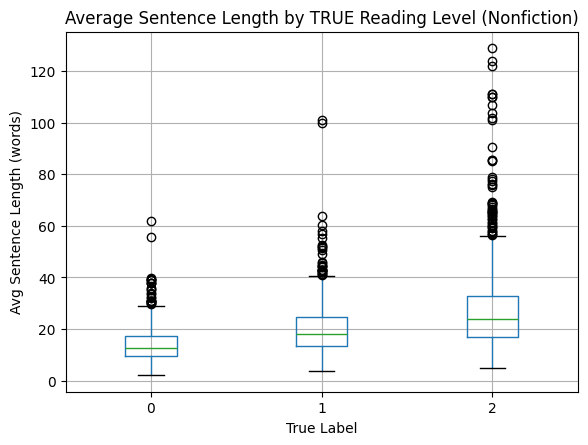

<Figure size 800x500 with 0 Axes>

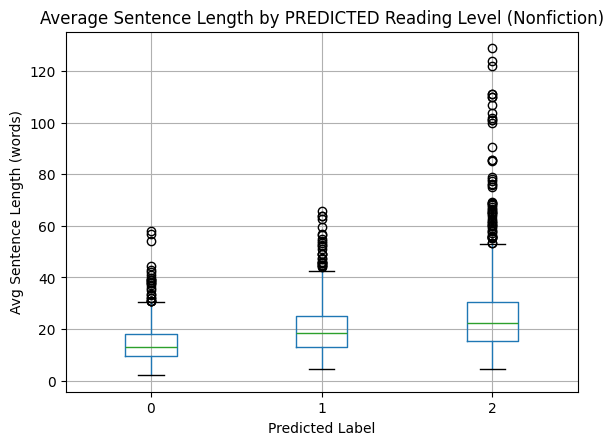

In [19]:
print("Average sentence length by TRUE label (OOD):")
print(ood_df.groupby("true_label")["avg_sentence_length"].describe())

print("\nAverage sentence length by PREDICTED label (OOD):")
print(ood_df.groupby("pred_label")["avg_sentence_length"].describe())

plt.figure(figsize=(8, 5))
ood_df.boxplot(column="avg_sentence_length", by="true_label")
plt.title("Average Sentence Length by TRUE Reading Level (Nonfiction)")
plt.suptitle("")
plt.xlabel("True Label")
plt.ylabel("Avg Sentence Length (words)")
plt.show()

plt.figure(figsize=(8, 5))
ood_df.boxplot(column="avg_sentence_length", by="pred_label")
plt.title("Average Sentence Length by PREDICTED Reading Level (Nonfiction)")
plt.suptitle("")
plt.xlabel("Predicted Label")
plt.ylabel("Avg Sentence Length (words)")
plt.show()


 Confusion Matrix (rows = TRUE, columns = PREDICTED):


,elementary,middle,high
elementary,391,161,136
middle,157,298,188
high,67,209,479


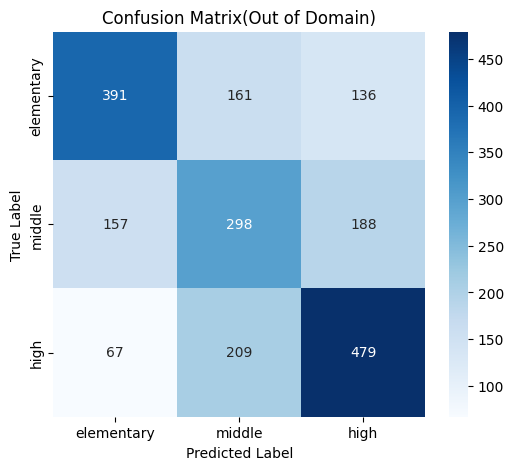

In [20]:
label_map = {0: "elementary", 1: "middle", 2: "high"}

ood_true_str = [label_map.get(x, x) for x in ood_df['true_label']]
ood_pred_str = [label_map.get(x, x) for x in ood_df['pred_label']]

class_names = ["elementary", "middle", "high"]

# Out of Domain confusion matrix
cm_ood = confusion_matrix(ood_true_str, ood_pred_str, labels=class_names)
cm_ood_df = pd.DataFrame(cm_ood, index=class_names, columns=class_names)

print("\n Confusion Matrix (rows = TRUE, columns = PREDICTED):")
display(cm_ood_df)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_ood_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix(Out of Domain)")
plt.show()

In [21]:
# More detail on OOD misclassification
ood_misclass_table = (
    ood_errors_df
    .groupby(["true_label_str", "pred_label_str"])
    .size()
    .unstack(fill_value=0)
)

print("\n Misclassified counts (rows = TRUE label, cols = PREDICTED label):")
display(ood_misclass_table)

labels_of_interest = ["elementary", "middle", "high"]

print("\n Misclassification breakdown by true label:")
for true_lab in labels_of_interest:
    if true_lab not in ood_misclass_table.index:
        continue  # skip labels that don't appear in OOD errors
    row = ood_misclass_table.loc[true_lab]
    print(f"\nTrue label = {true_lab}:")
    for pred_lab, count in row.items():
        if pred_lab == true_lab:
            continue
        print(f"  Misclassified as {pred_lab}: {count} examples")


 Misclassified counts (rows = TRUE label, cols = PREDICTED label):


pred_label_str,elementary,high,middle
true_label_str,,,
elementary,0,136,161
high,67,0,209
middle,157,188,0



 Misclassification breakdown by true label:

True label = elementary:
  Misclassified as high: 136 examples
  Misclassified as middle: 161 examples

True label = middle:
  Misclassified as elementary: 157 examples
  Misclassified as high: 188 examples

True label = high:
  Misclassified as elementary: 67 examples
  Misclassified as middle: 209 examples



[OOD] Per-class error summary (labels: elementary, middle, high):


,true_label,total_examples,correct,misclassified,error_rate,error_rate_percent
0,elementary,688,391,297,0.431686,43.2
1,middle,643,298,345,0.536547,53.7
2,high,755,479,276,0.365563,36.6


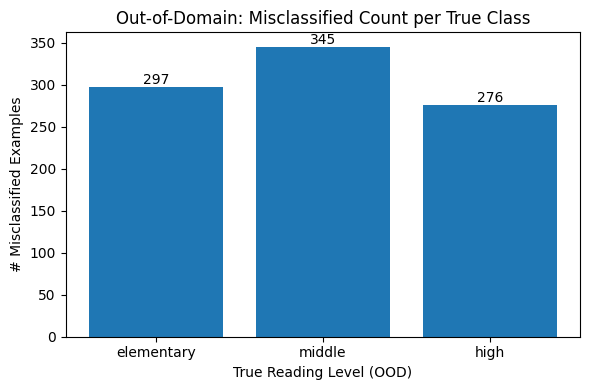

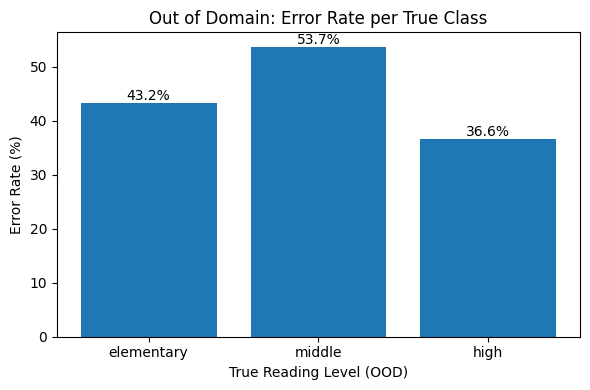

In [22]:
# Summary table + Bar charts

label_map = {0: "elementary", 1: "middle", 2: "high"}
ood_true_str = [label_map.get(x, x) for x in ood_df['true_label']]

all_labels = ["elementary", "middle", "high"]
present_labels = sorted(set(ood_true_str))
ood_unique_labels = [lbl for lbl in all_labels if lbl in present_labels]

# Misclassified count per true class
ood_mis_per_class = [
    (ood_errors_df["true_label_str"] == lbl).sum()
    for lbl in ood_unique_labels
]

# Total count per class
ood_total_per_class = [
    sum(1 for x in ood_true_str if x == lbl)
    for lbl in ood_unique_labels
]

# Summary table
ood_summary_rows = []
for i, lbl in enumerate(ood_unique_labels):
    total = ood_total_per_class[i]
    mis   = ood_mis_per_class[i]
    correct = total - mis
    err_rate = mis / total if total > 0 else 0.0
    ood_summary_rows.append({
        "true_label": lbl,
        "total_examples": total,
        "correct": correct,
        "misclassified": mis,
        "error_rate": err_rate,
    })

ood_summary_df = pd.DataFrame(ood_summary_rows)
ood_summary_df["error_rate_percent"] = (ood_summary_df["error_rate"] * 100).round(1)

print("\n[OOD] Per-class error summary (labels: elementary, middle, high):")
display(ood_summary_df)

# Bar chart - misclassified count per true class
plt.figure(figsize=(6, 4))
bars = plt.bar(range(len(ood_unique_labels)), ood_mis_per_class)
plt.xticks(range(len(ood_unique_labels)), ood_unique_labels)
plt.xlabel("True Reading Level (OOD)")
plt.ylabel("# Misclassified Examples")
plt.title("Out-of-Domain: Misclassified Count per True Class")

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f"{int(h)}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# Bar chart - error rate percentage
ood_error_rates = [
    ood_mis_per_class[i] / ood_total_per_class[i] if ood_total_per_class[i] > 0 else 0.0
    for i in range(len(ood_unique_labels))
]

plt.figure(figsize=(6, 4))
bars = plt.bar(range(len(ood_unique_labels)), [r * 100 for r in ood_error_rates])
plt.xticks(range(len(ood_unique_labels)), ood_unique_labels)
plt.xlabel("True Reading Level (OOD)")
plt.ylabel("Error Rate (%)")
plt.title("Out of Domain: Error Rate per True Class")

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f"{h:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()

In [23]:
# Checking distance based error
ordinal_map = {"elementary": 0, "middle": 1, "high": 2}

# Convert full OOD labels to ordinals
ood_true_ord = [ordinal_map[label_map.get(x, x)] for x in ood_df['true_label']]
ood_pred_ord = [ordinal_map[label_map.get(x, x)] for x in ood_df['pred_label']]

distances = [abs(t - p) for t, p in zip(ood_true_ord, ood_pred_ord)]

total_ood_examples = len(distances)
total_ood_errors = sum(d > 0 for d in distances)
ood_one_away = sum(d == 1 for d in distances)
ood_two_away = sum(d == 2 for d in distances)

print(f"Total OOD examples: {total_ood_examples}")
print(f"Total incorrect OOD predictions: {total_ood_errors}")

print("\nAmong incorrect OOD predictions:")
print(f"  1 level away: {ood_one_away}")
print(f"  2 levels away: {ood_two_away}")

if total_ood_errors > 0:
    print(f"\nFraction of OOD errors that are 1 level away: {ood_one_away / total_ood_errors:.3f}")
    print(f"Fraction of OOD errors that are 2 levels away: {ood_two_away / total_ood_errors:.3f}")

Total OOD examples: 2086
Total incorrect OOD predictions: 918

Among incorrect OOD predictions:
  1 level away: 715
  2 levels away: 203

Fraction of OOD errors that are 1 level away: 0.779
Fraction of OOD errors that are 2 levels away: 0.221


In [24]:
# Correct vs Incorrect Predictions & Length

ood_df["is_correct"] = (ood_df["true_label"] == ood_df["pred_label"]).astype(int)

print("\nAccuracy by true label (OOD):")
print(ood_df.groupby("true_label")["is_correct"].mean())

print("\nAccuracy by predicted label (OOD):")
print(ood_df.groupby("pred_label")["is_correct"].mean())

print("\nPassage length for correct vs incorrect predictions (OOD):")
print(ood_df.groupby("is_correct")["num_words"].describe())

print("\nAverage sentence length for correct vs incorrect predictions (OOD):")
print(ood_df.groupby("is_correct")["avg_sentence_length"].describe())


Accuracy by true label (OOD):
true_label
0    0.568314
1    0.463453
2    0.634437
Name: is_correct, dtype: float64

Accuracy by predicted label (OOD):
pred_label
0    0.635772
1    0.446108
2    0.596513
Name: is_correct, dtype: float64

Passage length for correct vs incorrect predictions (OOD):
             count       mean        std  min   25%   50%    75%    max
is_correct                                                             
0            918.0  82.201525  68.914798  5.0  38.0  66.0  102.0  652.0
1           1168.0  88.126712  74.602685  2.0  39.0  71.0  113.0  715.0

Average sentence length for correct vs incorrect predictions (OOD):
             count       mean        std  min        25%        50%  \
is_correct                                                            
0            918.0  19.618627  10.757221  3.5  12.446429  17.000000   
1           1168.0  22.090098  15.842422  2.0  12.083333  18.666667   

                  75%    max  
is_correct                  